In [157]:
import numpy as np
from datetime import datetime
from thesaurus import Word
from collections import defaultdict
import matplotlib.pyplot as plt

Reading the dataset to obtain tweets from the time period

In [103]:
def get_tweets(path="datasets/training_set_tweets.txt"):
    with open(path, encoding="utf8") as f:
        lines = f.readlines()
        
        tweets = []
        dates  = []

        split = lambda t: t.split('\t')
        
        for line in map(split, lines):
            if len(line) < 4 or len(line[3]) <= 10:
                continue
            try:
                dates.append(datetime.strptime(line[3][:10], "%Y-%m-%d"))
                tweets.append(line[2])
            except ValueError:
                continue
            
        
    return tweets, dates

In [21]:
tweets, dates = get_tweets()

Now let's write the sentiment analysis algo.

In [36]:
#Remember this takes ~1-2 min to run
def get_poms_synonyms():
    with open("poms.txt") as f:
        words = f.read().split(',')
        
        synonyms = {}
        for word in words:
            synonyms[word] = Word(word).synonyms()
            
    return synonyms

In [38]:
poms_synonyms = get_poms_synonyms()

In [78]:
def poms_scores(text, poms_synonyms):
    raw_scores = defaultdict(int)
    tokens = text.lower().split(' ')
    
    for token in tokens:
        for word in poms_synonyms:
            if token == word or token in poms_synonyms[word]:
                raw_scores[word] += 1
    
    scores = {}
    
    scores['tension'] = raw_scores['tense']         + \
                        raw_scores['shaky']         + \
                        raw_scores['on edge']       + \
                        raw_scores['panicky']       + \
                       -raw_scores['relaxed']       + \
                        raw_scores['uneasy']        + \
                        raw_scores['restless']      + \
                        raw_scores['nervous']       + \
                        raw_scores['anxious']
    
    scores['depression'] = raw_scores['unhappy']    + \
                        raw_scores['sorry']         + \
                        raw_scores['sad']           + \
                        raw_scores['blue']          + \
                        raw_scores['hopeless']      + \
                        raw_scores['unworthy']      + \
                        raw_scores['discouraged']   + \
                        raw_scores['lonely']        + \
                        raw_scores['helpless']      + \
                        raw_scores['worthless']     + \
                        raw_scores['terrified']     + \
                        raw_scores['guilty']        
    
    scores['anger'] =   raw_scores['angry']         + \
                        raw_scores['peeved']        + \
                        raw_scores['grouchy']       + \
                        raw_scores['spiteful']      + \
                        raw_scores['annoyed']       + \
                        raw_scores['resentful']     + \
                        raw_scores['bitter']        + \
                        raw_scores['ready to fight']+ \
                        raw_scores['rebellious']    + \
                        raw_scores['deceived']      + \
                        raw_scores['furious']       + \
                        raw_scores['bad tempered']  
    
    scores['fatigue'] = raw_scores['worn out']      + \
                        raw_scores['listless']      + \
                        raw_scores['fatigued']      + \
                        raw_scores['exhausted']     + \
                        raw_scores['sluggish']      + \
                        raw_scores['weary']         + \
                        raw_scores['bushed']
    
    scores['confusion'] = raw_scores['confused']     + \
                        raw_scores['distracted']     + \
                        raw_scores['muddled']        + \
                        raw_scores['bewildered']     + \
                       -raw_scores['efficient']      + \
                        raw_scores['forgetful']      + \
                        raw_scores['uncertain']
    
    scores['vigour'] =  raw_scores['lively']         + \
                        raw_scores['active']         + \
                        raw_scores['energetic']      + \
                        raw_scores['cheerful']       + \
                        raw_scores['alert']          + \
                        raw_scores['peppy']          + \
                        raw_scores['carefree']       + \
                        raw_scores['vigorous']

    
    return scores
        

Example tweet (demonstrated emotion):

In [101]:
tweets[9]

'...including his last failed relationship.  and while I know that none of it is grounded in reality, and I actually am worried about him...'

In [102]:
poms_scores(tweets[9], poms_synonyms)

{'tension': 5,
 'depression': 0,
 'anger': 0,
 'fatigue': 0,
 'confusion': 0,
 'vigour': 0}

Finally, we need to sort the Twitter dataset by day and plug each tweet into the POMS machine to get time series. Most of these functions will operate on millions of tweets so they'll probably take some time.

In [145]:
def sentiment_time_dict(tweets, dates, poms_synonyms):
    sent_dict = defaultdict(lambda: {'tension': 0,
                                     'depression': 0,
                                     'anger': 0,
                                     'fatigue': 0,
                                     'confusion': 0,
                                     'vigour': 0,
                                     'total': 0})
    start_date = datetime(2009, 9, 1)
    
    for tweet, date in zip(tweets, dates):
        scores = poms_scores(tweet, poms_synonyms)
        
        days = (date - start_date).days
        if days < 0:
            continue
        
        sent_dict[days]['tension'] += scores['tension']
        sent_dict[days]['depression'] += scores['depression']
        sent_dict[days]['anger'] += scores['anger']
        sent_dict[days]['fatigue'] += scores['fatigue']
        sent_dict[days]['confusion'] += scores['confusion']
        sent_dict[days]['vigour'] += scores['vigour']
        sent_dict[days]['total'] += 1
        
    for date in sent_dict:
        sent_dict[date]['tension'] /= sent_dict[date]['total']
        sent_dict[date]['depression'] /= sent_dict[date]['total']
        sent_dict[date]['anger'] /= sent_dict[date]['total']
        sent_dict[date]['fatigue'] /= sent_dict[date]['total']
        sent_dict[date]['confusion'] /= sent_dict[date]['total']
        sent_dict[date]['vigour'] /= sent_dict[date]['total']
        
    return sent_dict

In [188]:
sent_dict = sentiment_time_dict(tweets[:300000], dates[:300000], poms_synonyms)

In [202]:
def sentiment_time_series(sent_dict, key):
    N = max(sent_dict.keys())
    print(N)
    
    T = np.ndarray((N,))
    for i in range(N):
        T[i] = sent_dict[i][key]
        
    #convert to z-scores
    mean = np.mean(T)
    std  = np.std(T)
    T = (T - mean) / std
        
    return T

In [207]:
series = sentiment_time_series(sent_dict, 'tension')

98


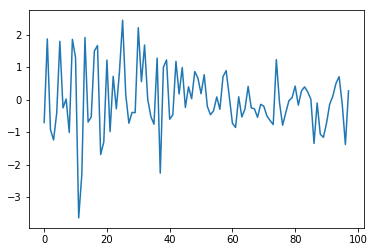

In [208]:
fig, ax = plt.subplots()
ax.plot(series)